In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.random import set_seed

from kaggle_prediction_interval_birthweight.data.data_processing import DataProcessor
from kaggle_prediction_interval_birthweight.workflow.validation import Validator
from kaggle_prediction_interval_birthweight.workflow.nn_tuning import (
    NeuralNetTuner,
)

np.random.seed(1)
set_seed(1)

In [3]:
data = pd.read_csv("~/dev/data/kaggle-prediction-interval-birthweight/train.csv")
data_test = pd.read_csv("~/dev/data/kaggle-prediction-interval-birthweight/test.csv")

In [4]:
data_processor = DataProcessor("MissingnessNeuralNetRegressor")
X, y = data_processor(data)

In [5]:
tuner = NeuralNetTuner(verbose=True)
tuner.tune(X, y)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0001
Function value obtained: 0.7339
Current minimum: 0.6915
Iteration No: 2 started. Evaluating function at random point.
{'dropout_rate': 0.5835601564025166, 'n_layers': 3, 'n_nodes_per_layer': 515}
1126/1126 [==============================] - 3s 2ms/step - loss: 0.6970
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2970.0774
Function value obtained: 0.6950
Current minimum: 0.6915
Iteration No: 3 started. Evaluating function at random point.
{'dropout_rate': 0.8125265649057131, 'n_layers': 2, 'n_nodes_per_layer': 234}
1126/1126 [==============================] - 1s 1ms/step - loss: 0.6907
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2772.9006
Function value obtained: 0.6905
Current minimum: 0.6905
Iteration No: 4 started. Evaluating function at random point.
{'dropout_rate': 0.31778114589002504, 'n_layers': 1, 

In [6]:
tuner.res_gp.func_vals

array([ 0.69154839,  0.69508183,  0.70045203,  0.69236992,  0.6995335 ,
        0.7559    ,  0.7339    ,  0.69498477,  0.69045524,  0.70065824,
        0.69114637,  0.68820417,  0.69411244,  0.70939726,  0.68997242,
        0.69070683,  0.69691994,  0.69473422,  0.6914115 ,  1.20096195,
        0.69356787,  0.69164614,  0.69371935,  0.8235173 , 35.26728068,
        0.71675567,  0.76874232,  0.70602852,  0.72567467,  0.71931992,
        0.69914019,  0.69867265])

In [7]:
tuner.res_gp.x_iters

[[0.6993763349606942, 2, 400],
 [0.6001020958459112, 2, 527],
 [0.33824438095671183, 2, 537],
 [0.6440753159765015, 3, 434],
 [0.5717923775592872, 1, 521],
 [0.9060878595993938, 1, 5],
 [0.6603084771373383, 1, 5],
 [0.5835601564025166, 3, 515],
 [0.8125265649057131, 2, 234],
 [0.31778114589002504, 1, 167],
 [0.47989860558921493, 3, 291],
 [0.4035063164907468, 3, 206],
 [0.6333546848460776, 2, 575],
 [0.17631570237138067, 3, 287],
 [0.77081967678168, 2, 409],
 [0.6985693892533251, 2, 325],
 [0.7327540618901216, 1, 287],
 [0.05, 3, 5],
 [0.95, 3, 600],
 [0.95, 3, 310],
 [0.8073418269158793, 3, 600],
 [0.48590071864411416, 3, 333],
 [0.7921562751222541, 3, 39],
 [0.05, 3, 600],
 [0.19179299855305515, 3, 5],
 [0.1995299219024077, 1, 449],
 [0.05, 3, 288],
 [0.3114267185399016, 1, 311],
 [0.13546957625539247, 3, 379],
 [0.52021364534323, 1, 5],
 [0.43749335634791475, 3, 600],
 [0.5829927871300723, 1, 186]]

In [8]:
tuner.result

{'score': 0.6882041692733765,
 'opt_parameters': {'dropout_rate': 0.4035063164907468,
  'n_layers': 3,
  'n_nodes_per_layer': 206}}

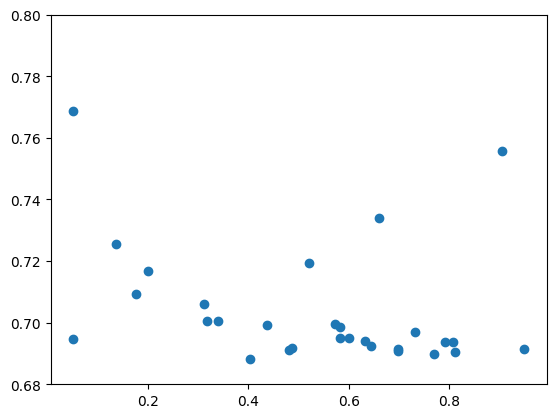

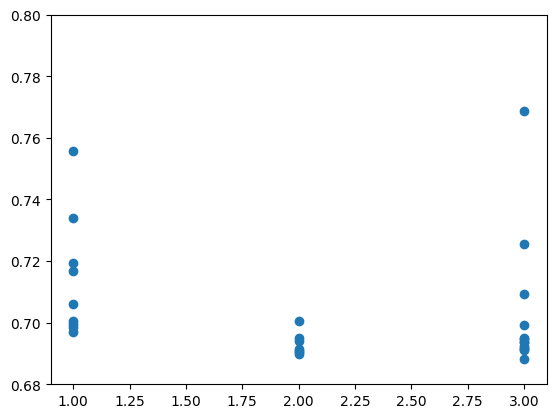

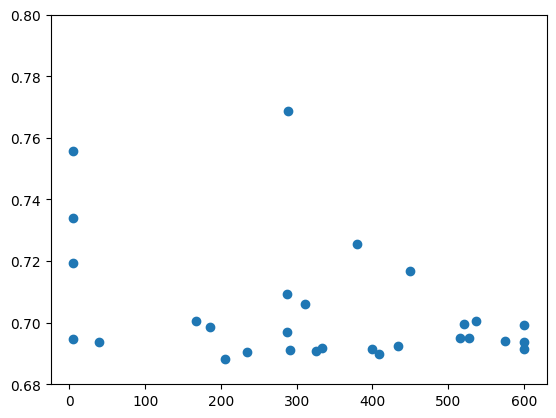

In [16]:
import matplotlib.pyplot as plt

for which_param in range(3):
    x = [i[which_param] for i in tuner.res_gp.x_iters]
    plt.scatter(x, tuner.res_gp.func_vals)
    plt.ylim(0.68, 0.8)
    plt.show()

In [ ]:
# def plot_result(obs, lower, upper, lower_new, upper_new):
#     fig, ax = plt.subplots(1, 3, figsize=(10, 3))
#     ax[0].vlines(x=obs, ymin=lower, ymax=upper, alpha=0.25)
#     ax[0].set_xlim(
#         np.min(np.concatenate([obs, lower])), np.max(np.concatenate([obs, upper]))
#     )
#     ax[0].set_ylim(
#         np.min(np.concatenate([obs, lower])), np.max(np.concatenate([obs, upper]))
#     )
#     ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes, color="orange")
#     ax[0].set_xlabel("observations")
#     ax[0].set_ylabel("predictions")
#     ax[1].hist(lower, bins=100, density=True, color="blue", alpha=0.75, label="train")
#     ax[1].hist(
#         lower_new, bins=100, density=True, color="orange", alpha=0.75, label="test"
#     )
#     ax[1].set_xlabel("predicted lower bounds")
#     ax[1].legend()
#     ax[2].hist(upper, bins=100, density=True, color="blue", alpha=0.75, label="train")
#     ax[2].hist(
#         upper_new, bins=100, density=True, color="orange", alpha=0.75, label="test"
#     )
#     ax[2].set_xlabel("predicted upper bounds")
#     ax[2].legend()
#     plt.show()

# eim_validator = Validator("HistBoostRegressor")
# eim_validator.fit(data)
# eim_validator.print_performance_summary()

# lower, upper = eim_validator.predict_intervals(data)
# lower_new, upper_new = eim_validator.predict_intervals(data_test)

# plot_result(data["DBWT"], lower, upper, lower_new, upper_new)